<a href="https://colab.research.google.com/github/adalbertii/modele-NLP/blob/main/CNN_news_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# aby upewnić się, że zestaw danych został dodany poprawnie

!ls '/content/drive/MyDrive/dane/20_newsgroup/'

alt.atheism		  comp.windows.x      rec.sport.hockey	soc.religion.christian
comp.graphics		  misc.forsale	      sci.crypt		talk.politics.guns
comp.os.ms-windows.misc   rec.autos	      sci.electronics	talk.politics.mideast
comp.sys.ibm.pc.hardware  rec.motorcycles     sci.med		talk.politics.misc
comp.sys.mac.hardware	  rec.sport.baseball  sci.space		talk.religion.misc


In [ ]:
# ścieżka zbioru danych
TEXT_DATA_DIR = r'/content/drive/MyDrive/dane/20_newsgroup/'

#ścieżka dla osadzeń Glove
GLOVE_DIR = r'/content/drive/MyDrive/dane/glove/'

# maksymalna długość słowa powinna być stała
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000

#
VALIDATION_SPLIT = 0.20

# wymiar wektorów, które mają zostać użyte
EMBEDDING_DIM = 100

# rozmiary filtrów różnych warstw konwolucji
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100


drop = 0.5
batch_size = 30
epochs = 2



STRUKTURA ZBIORU DANYCH

Zbiór danych ma strukturę hierarchiczną, tj. wszystkie pliki danej klasy znajdują się w odpowiednich folderach, a każda próbka danych ma swój własny plik ".txt".

    Najpierw przechodzimy przez cały zbiór danych, aby zbudować naszą listę tekstową i listę etykiet.
    Następnie tokenizujemy całe dane za pomocą Tokenizer, który jest częścią keras.preprocessing.text.
    Następnie dodajemy dopełnienie do sekwencji, aby nadać im jednolitą długość.



In [ ]:
## przygotowanie zbioru danych


texts = []  # lista próbek tekstu
labels_index = {}  # słownik mapujący nazwę etykiety na numeryczny identyfikator
labels = []  # lista ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # pomiń nagłówek
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)
print(labels_index)

print('Found %s texts.' % len(texts))

{'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
Found 19997 texts.


In [ ]:
texts[0]

'\n\nArchive-name: atheism/resources\nAlt-atheism-archive-name: resources\nLast-modified: 11 December 1992\nVersion: 1.0\n\n                              Atheist Resources\n\n                      Addresses of Atheist Organizations\n\n                                     USA\n\nFREEDOM FROM RELIGION FOUNDATION\n\nDarwin fish bumper stickers and assorted other atheist paraphernalia are\navailable from the Freedom From Religion Foundation in the US.\n\nWrite to:  FFRF, P.O. Box 750, Madison, WI 53701.\nTelephone: (608) 256-8900\n\nEVOLUTION DESIGNS\n\nEvolution Designs sell the "Darwin fish".  It\'s a fish symbol, like the ones\nChristians stick on their cars, but with feet and the word "Darwin" written\ninside.  The deluxe moulded 3D plastic fish is $4.95 postpaid in the US.\n\nWrite to:  Evolution Designs, 7119 Laurel Canyon #4, North Hollywood,\n           CA 91605.\n\nPeople in the San Francisco Bay area can get Darwin Fish from Lynn Gold --\ntry mailing <figmo@netcom.com>.  For net 

In [ ]:
labels[4000:4100]

In [ ]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

In [ ]:
sequences[0] # .count(5)

[1237,
 273,
 1213,
 1439,
 1071,
 1213,
 1237,
 273,
 1439,
 192,
 2515,
 348,
 2964,
 779,
 332,
 28,
 45,
 1628,
 1439,
 2516,
 3,
 1628,
 2144,
 780,
 937,
 29,
 441,
 2770,
 8854,
 4601,
 7969,
 5,
 75,
 1628,
 19,
 229,
 29,
 1,
 937,
 29,
 441,
 2770,
 6,
 1,
 118,
 558,
 2,
 90,
 106,
 482,
 3979,
 6602,
 5375,
 1871,
 1632,
 1828,
 5101,
 1828,
 5101,
 788,
 1,
 8854,
 4601,
 96,
 4,
 4601,
 5455,
 64,
 1,
 751,
 563,
 1716,
 15,
 71,
 844,
 24,
 20,
 1971,
 5,
 1,
 389,
 8854,
 744,
 1023,
 1,
 7762,
 1300,
 2912,
 4601,
 8,
 73,
 1698,
 6,
 1,
 118,
 558,
 2,
 1828,
 5101,
 73,
 1261,
 170,
 66,
 6,
 1,
 869,
 2235,
 2544,
 534,
 34,
 79,
 8854,
 4601,
 29,
 6603,
 3388,
 264,
 1505,
 535,
 49,
 12,
 343,
 66,
 60,
 155,
 2,
 6603,
 1043,
 1,
 427,
 8,
 73,
 1698,
 618,
 4601,
 417,
 1628,
 632,
 4602,
 814,
 1628,
 691,
 3,
 1,
 467,
 2163,
 3,
 2266,
 7491,
 5,
 48,
 15,
 40,
 135,
 378,
 8,
 1,
 467,
 6359,
 30,
 101,
 90,
 1781,
 5,
 115,
 101,
 417,
 1628,
 632,
 1448,


In [ ]:
word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))



unique words : 174074


In [ ]:
word_index

In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
data.shape[0]

19997

In [ ]:
# spodział danych na zestaw treningowy i zestaw walidacyjny
indices = np.arange(data.shape[0])
indices

array([    0,     1,     2, ..., 19994, 19995, 19996])

In [ ]:
np.random.shuffle(indices)
indices

array([ 7798, 16806, 18147, ..., 12689, 17556, 12521])

In [ ]:
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Ponieważ mamy już gotowy podział na trening i walidację, następnym krokiem jest utworzenie macierzy osadzania na podstawie wstępnie obliczonych osadzeń Glove. Dla wygody zamrażamy warstwę osadzania, tj. nie będziemy dostrajać osadzania słów.

In [ ]:
val= 'the -0.038194 -0.24487 0.72812'.split()
val

['the', '-0.038194', '-0.24487', '0.72812']

In [ ]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        # słowa, których nie znaleziono w indeksie osadzania, będą miały wszystkie zera
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)# !!! sieci nie uczymy współczynników Embeddings (te wartości pochodzą z pliku Glove)

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)


(None, 1000, 100)


In [ ]:
# !!! zmiana kształtu warstwy input
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)



(None, 1000, 100, 1)


<bound method KerasTensor.from_tensor of <class 'keras.src.engine.keras_tensor.KerasTensor'>>

In [ ]:
# budowa modelu
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

# definicja callback -a
checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# ustawienie parametró optymalizatora Adam
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            1740750   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 reshape (Reshape)           (None, 1000, 100, 1)         0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 998, 1, 512)          154112    ['reshape[0][0]']         

In [ ]:
x_val.shape

(3999, 1000)

In [ ]:
y_val.shape


(3999, 20)

In [ ]:
y_val[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [ ]:
# w przypadku  procesora klasy CPU czas jednej epoki trwa około 1310 sekund (21 min)
# w przypadku  procesora klasy GPU czas jednej epoki trwa około 12 sekund
print("Traning Model...")
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/20
534/534 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.0864

534/534 [==============================] - 26s 21ms/step - loss: 0.2569 - accuracy: 0.0864 - val_loss: 0.1747 - val_accuracy: 0.4571
Epoch 2/20
531/534 [============================>.] - ETA: 0s - loss: 0.1821 - accuracy: 0.2382

534/534 [==============================] - 11s 21ms/step - loss: 0.1820 - accuracy: 0.2385 - val_loss: 0.1422 - val_accuracy: 0.6027
Epoch 3/20
532/534 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.3940

534/534 [==============================] - 11s 21ms/step - loss: 0.1507 - accuracy: 0.3944 - val_loss: 0.1236 - val_accuracy: 0.6572
Epoch 4/20
532/534 [============================>.] - ETA: 0s - loss: 0.1286 - accuracy: 0.5178

534/534 [==============================] - 11s 20ms/step - loss: 0.1286 - accuracy: 0.5181 - val_loss: 0.1109 - val_accuracy: 0.6944
Epoch 5/20
532/534 [============================>.] - ETA: 0s - loss: 0.1143 - accuracy: 0.5987

534/534 [==============================] - 11s 20ms/step - loss: 0.1143 - accuracy: 0.5989 - val_loss: 0.1016 - val_accuracy: 0.7129
Epoch 6/20
532/534 [============================>.] - ETA: 0s - loss: 0.1039 - accuracy: 0.6548

534/534 [==============================] - 11s 20ms/step - loss: 0.1039 - accuracy: 0.6550 - val_loss: 0.0946 - val_accuracy: 0.7262
Epoch 7/20
532/534 [============================>.] - ETA: 0s - loss: 0.0948 - accuracy: 0.7014

534/534 [==============================] - 11s 20ms/step - loss: 0.0947 - accuracy: 0.7015 - val_loss: 0.0898 - val_accuracy: 0.7382
Epoch 8/20
532/534 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.7271

534/534 [==============================] - 11s 20ms/step - loss: 0.0884 - accuracy: 0.7271 - val_loss: 0.0857 - val_accuracy: 0.7447
Epoch 9/20
532/534 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.7449

534/534 [==============================] - 11s 20ms/step - loss: 0.0828 - accuracy: 0.7449 - val_loss: 0.0815 - val_accuracy: 0.7597
Epoch 10/20
532/534 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.7682

534/534 [==============================] - 11s 20ms/step - loss: 0.0779 - accuracy: 0.7683 - val_loss: 0.0783 - val_accuracy: 0.7637
Epoch 11/20
532/534 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.7880

534/534 [==============================] - 11s 20ms/step - loss: 0.0730 - accuracy: 0.7878 - val_loss: 0.0762 - val_accuracy: 0.7657
Epoch 12/20
532/534 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.7986

534/534 [==============================] - 11s 20ms/step - loss: 0.0694 - accuracy: 0.7984 - val_loss: 0.0731 - val_accuracy: 0.7764
Epoch 13/20
531/534 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.8158

534/534 [==============================] - 11s 20ms/step - loss: 0.0659 - accuracy: 0.8155 - val_loss: 0.0714 - val_accuracy: 0.7754
Epoch 14/20
531/534 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.8273

534/534 [==============================] - 11s 20ms/step - loss: 0.0625 - accuracy: 0.8271 - val_loss: 0.0698 - val_accuracy: 0.7874
Epoch 15/20
532/534 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.8350

534/534 [==============================] - 11s 20ms/step - loss: 0.0597 - accuracy: 0.8347 - val_loss: 0.0679 - val_accuracy: 0.7879
Epoch 16/20
531/534 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.8491

534/534 [==============================] - 11s 20ms/step - loss: 0.0570 - accuracy: 0.8492 - val_loss: 0.0672 - val_accuracy: 0.7894
Epoch 17/20
532/534 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.8558

534/534 [==============================] - 11s 20ms/step - loss: 0.0548 - accuracy: 0.8557 - val_loss: 0.0656 - val_accuracy: 0.7937
Epoch 18/20
531/534 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.8662

534/534 [==============================] - 11s 20ms/step - loss: 0.0522 - accuracy: 0.8664 - val_loss: 0.0649 - val_accuracy: 0.7959
Epoch 19/20
532/534 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.8707

534/534 [==============================] - 11s 20ms/step - loss: 0.0507 - accuracy: 0.8705 - val_loss: 0.0642 - val_accuracy: 0.8002
Epoch 20/20
531/534 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.8797

534/534 [==============================] - 11s 20ms/step - loss: 0.0485 - accuracy: 0.8796 - val_loss: 0.0629 - val_accuracy: 0.7989


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


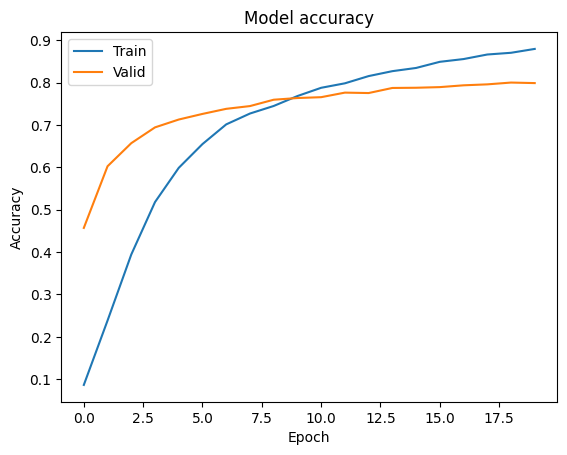

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

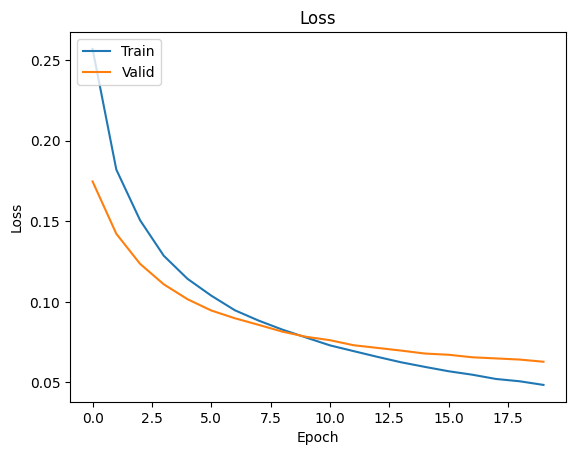

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
# ewaluacja modelu
eval = model.evaluate(x_val, y_val)

125/125 [==============================] - 1s 8ms/step - loss: 0.0629 - accuracy: 0.7989


In [ ]:
# predykcja dla całego zbioru testowego
Y_pred = model.predict(x_val)


125/125 [==============================] - 1s 6ms/step


In [ ]:
Y_pred[0]

array([4.7214115e-03, 1.6824719e-02, 2.4247383e-01, 9.7516514e-02,
       6.8273172e-02, 3.5657221e-01, 1.1681961e-01, 9.1628609e-03,
       6.0619214e-03, 3.1983538e-04, 7.6423064e-05, 3.2503288e-02,
       1.6708042e-02, 3.1751924e-04, 3.3030116e-03, 5.4058371e-05,
       6.0409540e-03, 5.5041667e-03, 6.5842392e-03, 1.0162074e-02],
      dtype=float32)

In [ ]:
# sformatowanie tablic na potrzeby "confusion_matrix"
Y_pred_classes =np.argmax(Y_pred, axis=1)
Y_true= np.argmax(y_val, axis=1)

In [ ]:
# Macierz konfuzji
from sklearn.metrics import classification_report,confusion_matrix

confusion_m= confusion_matrix(Y_true, Y_pred_classes)
print(confusion_m)


[[127   0   0   0   0   0   0   0   0   1   2   0   0   0   2  26   2   3
    0  42]
 [  0 137   9   7   4  15   2   0   0   1   0   1   4   2   2   2   0   0
    0   1]
 [  0  11 149   9   0  11   3   0   2   1   1   0   0   1   2   0   0   0
    0   0]
 [  0   9  11 155  10   3   7   2   0   1   0   0  19   0   0   0   0   0
    0   0]
 [  0   8   2  13 133   1  10   4   2   0   0   1  15   0   2   0   0   0
    0   0]
 [  0  14   1   6   1 177   4   1   0   1   0   0   1   0   3   2   0   0
    0   0]
 [  0   4   4   9   3   2 161   5   3   3   0   1   7   2   1   0   0   0
    0   1]
 [  0   0   0   0   0   1   5 170   7   3   0   0   5   0   1   0   4   1
    1   0]
 [  0   1   0   1   2   1   5   4 170   1   0   0   0   2   1   0   2   1
    0   0]
 [  0   1   0   0   0   0   2   0   0 188   2   1   0   0   2   1   2   1
    1   0]
 [  0   0   0   0   0   2   1   0   0   4 201   0   0   1   0   0   1   0
    0   0]
 [  0   0   2   0   1   1   0   0   1   0   2 208   2   0   1   0

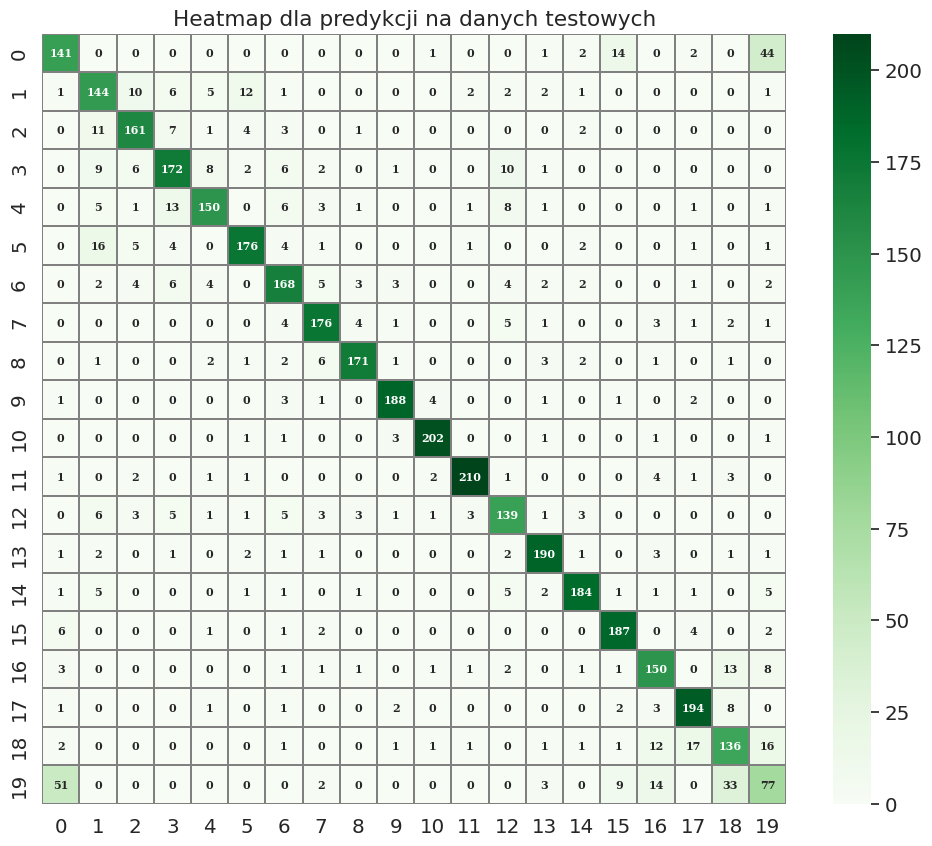

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(confusion_m, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.0f',annot_kws={"fontsize": 8, "fontweight": "bold", "fontfamily": "serif"})
plt.title("Heatmap dla predykcji na danych testowych")
plt.savefig("heatmap.png")
plt.show()

In [ ]:
# Raport klasyfikacji
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.72      0.62      0.66       205
           1       0.68      0.73      0.71       187
           2       0.82      0.78      0.80       190
           3       0.74      0.71      0.73       217
           4       0.85      0.70      0.76       191
           5       0.78      0.84      0.81       211
           6       0.77      0.78      0.77       206
           7       0.88      0.86      0.87       198
           8       0.87      0.89      0.88       191
           9       0.88      0.94      0.91       201
          10       0.94      0.96      0.95       210
          11       0.93      0.92      0.93       226
          12       0.66      0.73      0.69       175
          13       0.90      0.89      0.90       206
          14       0.88      0.88      0.88       208
          15       0.77      0.93      0.84       203
          16       0.70      0.84      0.76       183
          17       0.87    

In [ ]:
print("Traning Model...")
epochs = 80
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/80
531/534 [============================>.] - ETA: 0s - loss: 0.0465 - accuracy: 0.8854

534/534 [==============================] - 11s 21ms/step - loss: 0.0465 - accuracy: 0.8853 - val_loss: 0.0621 - val_accuracy: 0.8045
Epoch 2/80
532/534 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.8948

534/534 [==============================] - 11s 20ms/step - loss: 0.0446 - accuracy: 0.8948 - val_loss: 0.0619 - val_accuracy: 0.8010
Epoch 3/80
532/534 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.8961

534/534 [==============================] - 11s 21ms/step - loss: 0.0431 - accuracy: 0.8962 - val_loss: 0.0611 - val_accuracy: 0.8100
Epoch 4/80
531/534 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9008

534/534 [==============================] - 11s 21ms/step - loss: 0.0417 - accuracy: 0.9007 - val_loss: 0.0611 - val_accuracy: 0.8070
Epoch 5/80
531/534 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9112

534/534 [==============================] - 11s 21ms/step - loss: 0.0400 - accuracy: 0.9114 - val_loss: 0.0603 - val_accuracy: 0.8095
Epoch 6/80
532/534 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9131

534/534 [==============================] - 11s 20ms/step - loss: 0.0387 - accuracy: 0.9132 - val_loss: 0.0599 - val_accuracy: 0.8122
Epoch 7/80
531/534 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9193

534/534 [==============================] - 11s 21ms/step - loss: 0.0370 - accuracy: 0.9194 - val_loss: 0.0598 - val_accuracy: 0.8130
Epoch 8/80
532/534 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9222

534/534 [==============================] - 11s 21ms/step - loss: 0.0361 - accuracy: 0.9222 - val_loss: 0.0591 - val_accuracy: 0.8077
Epoch 9/80
531/534 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9274

534/534 [==============================] - 11s 21ms/step - loss: 0.0348 - accuracy: 0.9274 - val_loss: 0.0589 - val_accuracy: 0.8112
Epoch 10/80
532/534 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9268

534/534 [==============================] - 11s 21ms/step - loss: 0.0336 - accuracy: 0.9268 - val_loss: 0.0586 - val_accuracy: 0.8155
Epoch 11/80
532/534 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9310

534/534 [==============================] - 11s 20ms/step - loss: 0.0327 - accuracy: 0.9309 - val_loss: 0.0585 - val_accuracy: 0.8150
Epoch 12/80
532/534 [============================>.] - ETA: 0s - loss: 0.0317 - accuracy: 0.9325

534/534 [==============================] - 11s 20ms/step - loss: 0.0317 - accuracy: 0.9325 - val_loss: 0.0586 - val_accuracy: 0.8182
Epoch 13/80
531/534 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9372

534/534 [==============================] - 11s 20ms/step - loss: 0.0306 - accuracy: 0.9372 - val_loss: 0.0581 - val_accuracy: 0.8180
Epoch 14/80
532/534 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9399

534/534 [==============================] - 11s 20ms/step - loss: 0.0298 - accuracy: 0.9397 - val_loss: 0.0585 - val_accuracy: 0.8180
Epoch 15/80
532/534 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9402

534/534 [==============================] - 11s 20ms/step - loss: 0.0291 - accuracy: 0.9403 - val_loss: 0.0583 - val_accuracy: 0.8187
Epoch 16/80
532/534 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 0.9412

534/534 [==============================] - 11s 20ms/step - loss: 0.0285 - accuracy: 0.9411 - val_loss: 0.0581 - val_accuracy: 0.8185
Epoch 17/80
531/534 [============================>.] - ETA: 0s - loss: 0.0275 - accuracy: 0.9455

534/534 [==============================] - 11s 21ms/step - loss: 0.0275 - accuracy: 0.9456 - val_loss: 0.0582 - val_accuracy: 0.8197
Epoch 18/80
532/534 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9479

534/534 [==============================] - 11s 21ms/step - loss: 0.0263 - accuracy: 0.9479 - val_loss: 0.0580 - val_accuracy: 0.8225
Epoch 19/80
532/534 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9496

534/534 [==============================] - 11s 21ms/step - loss: 0.0257 - accuracy: 0.9497 - val_loss: 0.0582 - val_accuracy: 0.8222
Epoch 20/80
531/534 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 0.9517

534/534 [==============================] - 11s 20ms/step - loss: 0.0251 - accuracy: 0.9516 - val_loss: 0.0583 - val_accuracy: 0.8227
Epoch 21/80
532/534 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9514

534/534 [==============================] - 11s 20ms/step - loss: 0.0246 - accuracy: 0.9514 - val_loss: 0.0586 - val_accuracy: 0.8182
Epoch 22/80
532/534 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9541

534/534 [==============================] - 11s 20ms/step - loss: 0.0238 - accuracy: 0.9542 - val_loss: 0.0582 - val_accuracy: 0.8215
Epoch 23/80
532/534 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9564

534/534 [==============================] - 11s 20ms/step - loss: 0.0231 - accuracy: 0.9562 - val_loss: 0.0581 - val_accuracy: 0.8212
Epoch 24/80
531/534 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9584

534/534 [==============================] - 11s 20ms/step - loss: 0.0228 - accuracy: 0.9585 - val_loss: 0.0588 - val_accuracy: 0.8230
Epoch 25/80
532/534 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9571

534/534 [==============================] - 11s 20ms/step - loss: 0.0225 - accuracy: 0.9571 - val_loss: 0.0584 - val_accuracy: 0.8207
Epoch 26/80
531/534 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9578

534/534 [==============================] - 11s 20ms/step - loss: 0.0215 - accuracy: 0.9576 - val_loss: 0.0590 - val_accuracy: 0.8215
Epoch 27/80
532/534 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9586

534/534 [==============================] - 11s 20ms/step - loss: 0.0211 - accuracy: 0.9586 - val_loss: 0.0592 - val_accuracy: 0.8230
Epoch 28/80
532/534 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9603

534/534 [==============================] - 11s 20ms/step - loss: 0.0211 - accuracy: 0.9602 - val_loss: 0.0587 - val_accuracy: 0.8257
Epoch 29/80
532/534 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9607

534/534 [==============================] - 11s 20ms/step - loss: 0.0203 - accuracy: 0.9607 - val_loss: 0.0597 - val_accuracy: 0.8245
Epoch 30/80
532/534 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9617

534/534 [==============================] - 11s 20ms/step - loss: 0.0202 - accuracy: 0.9616 - val_loss: 0.0594 - val_accuracy: 0.8235
Epoch 31/80
532/534 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9617

534/534 [==============================] - 11s 21ms/step - loss: 0.0197 - accuracy: 0.9617 - val_loss: 0.0595 - val_accuracy: 0.8262
Epoch 32/80
532/534 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9618

534/534 [==============================] - 11s 21ms/step - loss: 0.0196 - accuracy: 0.9617 - val_loss: 0.0600 - val_accuracy: 0.8227
Epoch 33/80
532/534 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9630

534/534 [==============================] - 11s 20ms/step - loss: 0.0190 - accuracy: 0.9631 - val_loss: 0.0603 - val_accuracy: 0.8255
Epoch 34/80
532/534 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9625

534/534 [==============================] - 11s 20ms/step - loss: 0.0189 - accuracy: 0.9626 - val_loss: 0.0605 - val_accuracy: 0.8220
Epoch 35/80
532/534 [============================>.] - ETA: 0s - loss: 0.0183 - accuracy: 0.9629

534/534 [==============================] - 11s 20ms/step - loss: 0.0183 - accuracy: 0.9629 - val_loss: 0.0602 - val_accuracy: 0.8257
Epoch 36/80
532/534 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9667

534/534 [==============================] - 11s 20ms/step - loss: 0.0181 - accuracy: 0.9668 - val_loss: 0.0601 - val_accuracy: 0.8250
Epoch 37/80
532/534 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9654

534/534 [==============================] - 11s 20ms/step - loss: 0.0177 - accuracy: 0.9654 - val_loss: 0.0614 - val_accuracy: 0.8247
Epoch 38/80
532/534 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9654

534/534 [==============================] - 11s 20ms/step - loss: 0.0174 - accuracy: 0.9654 - val_loss: 0.0605 - val_accuracy: 0.8267
Epoch 39/80
532/534 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9660

534/534 [==============================] - 11s 20ms/step - loss: 0.0172 - accuracy: 0.9660 - val_loss: 0.0604 - val_accuracy: 0.8235
Epoch 40/80
532/534 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9658

534/534 [==============================] - 11s 20ms/step - loss: 0.0167 - accuracy: 0.9659 - val_loss: 0.0610 - val_accuracy: 0.8252
Epoch 41/80
532/534 [============================>.] - ETA: 0s - loss: 0.0170 - accuracy: 0.9654

534/534 [==============================] - 11s 20ms/step - loss: 0.0170 - accuracy: 0.9654 - val_loss: 0.0611 - val_accuracy: 0.8255
Epoch 42/80
532/534 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9662

534/534 [==============================] - 11s 20ms/step - loss: 0.0166 - accuracy: 0.9662 - val_loss: 0.0615 - val_accuracy: 0.8220
Epoch 43/80
532/534 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 0.9676

534/534 [==============================] - 11s 21ms/step - loss: 0.0162 - accuracy: 0.9677 - val_loss: 0.0623 - val_accuracy: 0.8230
Epoch 44/80
532/534 [============================>.] - ETA: 0s - loss: 0.0161 - accuracy: 0.9692

534/534 [==============================] - 11s 20ms/step - loss: 0.0161 - accuracy: 0.9692 - val_loss: 0.0620 - val_accuracy: 0.8247
Epoch 45/80
531/534 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9669

534/534 [==============================] - 11s 21ms/step - loss: 0.0160 - accuracy: 0.9668 - val_loss: 0.0620 - val_accuracy: 0.8222
Epoch 46/80
532/534 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9667

534/534 [==============================] - 11s 20ms/step - loss: 0.0159 - accuracy: 0.9668 - val_loss: 0.0616 - val_accuracy: 0.8257
Epoch 47/80
532/534 [============================>.] - ETA: 0s - loss: 0.0156 - accuracy: 0.9677

534/534 [==============================] - 11s 20ms/step - loss: 0.0156 - accuracy: 0.9677 - val_loss: 0.0618 - val_accuracy: 0.8282
Epoch 48/80
531/534 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9671

534/534 [==============================] - 11s 20ms/step - loss: 0.0152 - accuracy: 0.9672 - val_loss: 0.0631 - val_accuracy: 0.8267
Epoch 49/80
532/534 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9697

534/534 [==============================] - 11s 20ms/step - loss: 0.0149 - accuracy: 0.9698 - val_loss: 0.0622 - val_accuracy: 0.8240
Epoch 50/80
532/534 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9686

534/534 [==============================] - 11s 20ms/step - loss: 0.0147 - accuracy: 0.9686 - val_loss: 0.0629 - val_accuracy: 0.8260
Epoch 51/80
532/534 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9684

534/534 [==============================] - 11s 20ms/step - loss: 0.0146 - accuracy: 0.9684 - val_loss: 0.0623 - val_accuracy: 0.8300
Epoch 52/80
532/534 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9680

534/534 [==============================] - 11s 20ms/step - loss: 0.0147 - accuracy: 0.9680 - val_loss: 0.0623 - val_accuracy: 0.8272
Epoch 53/80
532/534 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9698

534/534 [==============================] - 11s 20ms/step - loss: 0.0141 - accuracy: 0.9697 - val_loss: 0.0640 - val_accuracy: 0.8242
Epoch 54/80
532/534 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9690

534/534 [==============================] - 11s 20ms/step - loss: 0.0143 - accuracy: 0.9690 - val_loss: 0.0633 - val_accuracy: 0.8282
Epoch 55/80
531/534 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9672

534/534 [==============================] - 11s 21ms/step - loss: 0.0142 - accuracy: 0.9672 - val_loss: 0.0643 - val_accuracy: 0.8267
Epoch 56/80
532/534 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9694

534/534 [==============================] - 11s 20ms/step - loss: 0.0141 - accuracy: 0.9694 - val_loss: 0.0636 - val_accuracy: 0.8282
Epoch 57/80
532/534 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9697

534/534 [==============================] - 11s 20ms/step - loss: 0.0137 - accuracy: 0.9697 - val_loss: 0.0656 - val_accuracy: 0.8240
Epoch 58/80
532/534 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.9692

534/534 [==============================] - 11s 20ms/step - loss: 0.0135 - accuracy: 0.9692 - val_loss: 0.0650 - val_accuracy: 0.8272
Epoch 59/80
532/534 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9682

534/534 [==============================] - 11s 20ms/step - loss: 0.0138 - accuracy: 0.9682 - val_loss: 0.0652 - val_accuracy: 0.8280
Epoch 60/80
532/534 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9697

534/534 [==============================] - 11s 21ms/step - loss: 0.0136 - accuracy: 0.9698 - val_loss: 0.0641 - val_accuracy: 0.8237
Epoch 61/80
531/534 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9702

534/534 [==============================] - 11s 20ms/step - loss: 0.0133 - accuracy: 0.9702 - val_loss: 0.0652 - val_accuracy: 0.8300
Epoch 62/80
531/534 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9700

534/534 [==============================] - 11s 20ms/step - loss: 0.0129 - accuracy: 0.9701 - val_loss: 0.0652 - val_accuracy: 0.8297
Epoch 63/80
532/534 [============================>.] - ETA: 0s - loss: 0.0133 - accuracy: 0.9683

534/534 [==============================] - 11s 20ms/step - loss: 0.0133 - accuracy: 0.9682 - val_loss: 0.0642 - val_accuracy: 0.8280
Epoch 64/80
531/534 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9700

534/534 [==============================] - 11s 20ms/step - loss: 0.0130 - accuracy: 0.9700 - val_loss: 0.0655 - val_accuracy: 0.8302
Epoch 65/80
532/534 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9699

534/534 [==============================] - 11s 20ms/step - loss: 0.0129 - accuracy: 0.9699 - val_loss: 0.0655 - val_accuracy: 0.8285
Epoch 66/80
532/534 [============================>.] - ETA: 0s - loss: 0.0129 - accuracy: 0.9699

534/534 [==============================] - 11s 20ms/step - loss: 0.0129 - accuracy: 0.9699 - val_loss: 0.0661 - val_accuracy: 0.8292
Epoch 67/80
532/534 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9709

534/534 [==============================] - 11s 20ms/step - loss: 0.0124 - accuracy: 0.9709 - val_loss: 0.0667 - val_accuracy: 0.8287
Epoch 68/80
531/534 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9706

534/534 [==============================] - 11s 20ms/step - loss: 0.0123 - accuracy: 0.9706 - val_loss: 0.0660 - val_accuracy: 0.8285
Epoch 69/80
532/534 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9692

534/534 [==============================] - 11s 20ms/step - loss: 0.0126 - accuracy: 0.9692 - val_loss: 0.0672 - val_accuracy: 0.8282
Epoch 70/80
531/534 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9694

534/534 [==============================] - 11s 21ms/step - loss: 0.0124 - accuracy: 0.9692 - val_loss: 0.0678 - val_accuracy: 0.8257
Epoch 71/80
532/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9721

534/534 [==============================] - 11s 21ms/step - loss: 0.0121 - accuracy: 0.9721 - val_loss: 0.0675 - val_accuracy: 0.8285
Epoch 72/80
532/534 [============================>.] - ETA: 0s - loss: 0.0124 - accuracy: 0.9703

534/534 [==============================] - 11s 21ms/step - loss: 0.0124 - accuracy: 0.9704 - val_loss: 0.0673 - val_accuracy: 0.8305
Epoch 73/80
531/534 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9725

534/534 [==============================] - 11s 21ms/step - loss: 0.0123 - accuracy: 0.9724 - val_loss: 0.0662 - val_accuracy: 0.8295
Epoch 74/80
532/534 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9702

534/534 [==============================] - 11s 21ms/step - loss: 0.0121 - accuracy: 0.9701 - val_loss: 0.0670 - val_accuracy: 0.8310
Epoch 75/80
533/534 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9727

534/534 [==============================] - 11s 21ms/step - loss: 0.0117 - accuracy: 0.9727 - val_loss: 0.0678 - val_accuracy: 0.8305
Epoch 76/80
531/534 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9706

534/534 [==============================] - 11s 21ms/step - loss: 0.0120 - accuracy: 0.9706 - val_loss: 0.0685 - val_accuracy: 0.8310
Epoch 77/80
532/534 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9692

534/534 [==============================] - 11s 20ms/step - loss: 0.0119 - accuracy: 0.9691 - val_loss: 0.0675 - val_accuracy: 0.8280
Epoch 78/80
532/534 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9695

534/534 [==============================] - 11s 21ms/step - loss: 0.0120 - accuracy: 0.9695 - val_loss: 0.0686 - val_accuracy: 0.8287
Epoch 79/80
532/534 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9709

534/534 [==============================] - 11s 21ms/step - loss: 0.0115 - accuracy: 0.9708 - val_loss: 0.0691 - val_accuracy: 0.8277
Epoch 80/80
532/534 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9694

534/534 [==============================] - 11s 21ms/step - loss: 0.0117 - accuracy: 0.9694 - val_loss: 0.0698 - val_accuracy: 0.8292


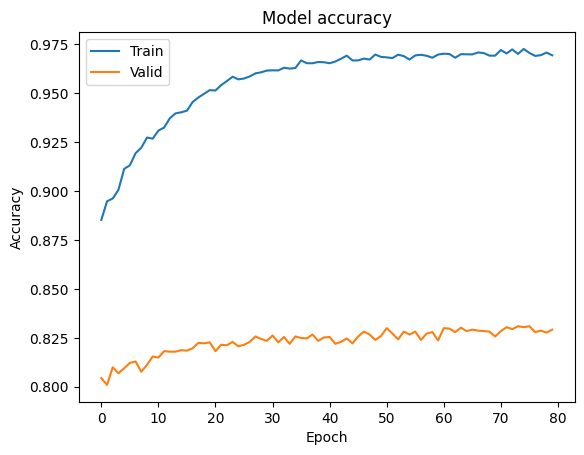

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

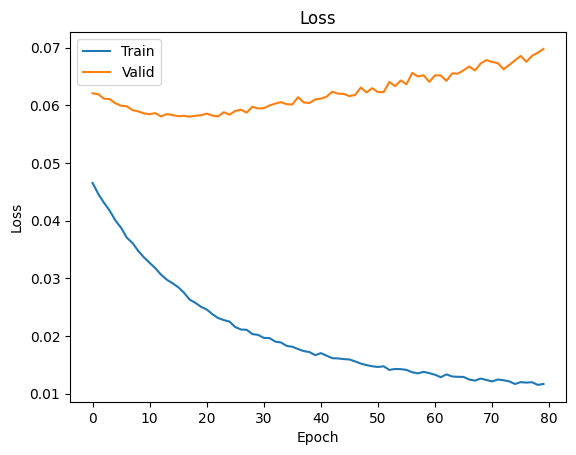

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
# ewaluacja modelu (po 80 epokach)
eval = model.evaluate(x_val, y_val)

125/125 [==============================] - 1s 7ms/step - loss: 0.0698 - accuracy: 0.8292


In [ ]:
# predykcja dla całego zbioru testowego
Y_pred = model.predict(x_val)

125/125 [==============================] - 1s 6ms/step


In [ ]:
# sformatowanie tablic na potrzeby "confusion_matrix"
Y_pred_classes =np.argmax(Y_pred, axis=1)
Y_true= np.argmax(y_val, axis=1)

In [ ]:
# Macierz konfuzji
from sklearn.metrics import classification_report,confusion_matrix
sns.set(font_scale=1.3)

confusion_m= confusion_matrix(Y_true, Y_pred_classes)
print(confusion_m)

[[141   0   0   0   0   0   0   0   0   0   1   0   0   1   2  14   0   2
    0  44]
 [  1 144  10   6   5  12   1   0   0   0   0   2   2   2   1   0   0   0
    0   1]
 [  0  11 161   7   1   4   3   0   1   0   0   0   0   0   2   0   0   0
    0   0]
 [  0   9   6 172   8   2   6   2   0   1   0   0  10   1   0   0   0   0
    0   0]
 [  0   5   1  13 150   0   6   3   1   0   0   1   8   1   0   0   0   1
    0   1]
 [  0  16   5   4   0 176   4   1   0   0   0   1   0   0   2   0   0   1
    0   1]
 [  0   2   4   6   4   0 168   5   3   3   0   0   4   2   2   0   0   1
    0   2]
 [  0   0   0   0   0   0   4 176   4   1   0   0   5   1   0   0   3   1
    2   1]
 [  0   1   0   0   2   1   2   6 171   1   0   0   0   3   2   0   1   0
    1   0]
 [  1   0   0   0   0   0   3   1   0 188   4   0   0   1   0   1   0   2
    0   0]
 [  0   0   0   0   0   1   1   0   0   3 202   0   0   1   0   0   1   0
    0   1]
 [  1   0   2   0   1   1   0   0   0   0   2 210   1   0   0   0

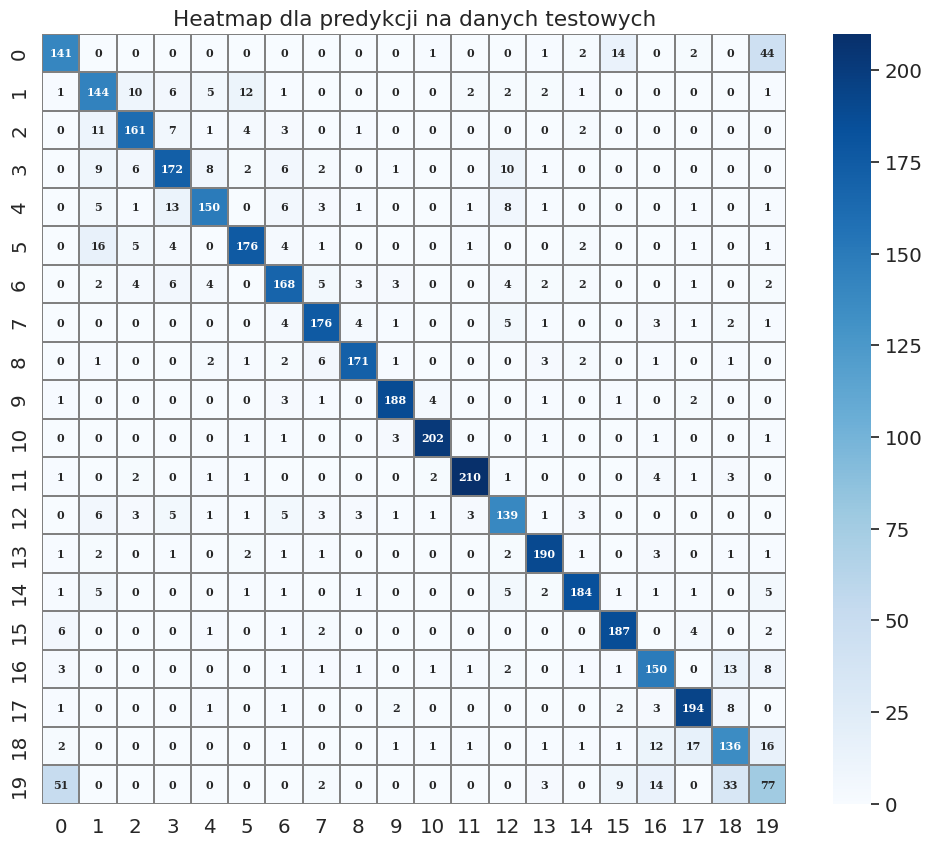

In [ ]:
sns.set(font_scale=1.3)
plt.figure(figsize=(12,10))
sns.heatmap(confusion_m, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray",annot_kws={"fontsize": 8, "fontweight": "bold", "fontfamily": "serif"}, fmt= '.0f') #, fmt= '.1f'
plt.title("Heatmap dla predykcji na danych testowych")
plt.savefig("heatmap.png")
plt.show()

In [ ]:
# Raport klasyfikacji
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       205
           1       0.72      0.77      0.74       187
           2       0.84      0.85      0.84       190
           3       0.80      0.79      0.80       217
           4       0.86      0.79      0.82       191
           5       0.88      0.83      0.85       211
           6       0.80      0.82      0.81       206
           7       0.87      0.89      0.88       198
           8       0.92      0.90      0.91       191
           9       0.94      0.94      0.94       201
          10       0.95      0.96      0.96       210
          11       0.96      0.93      0.94       226
          12       0.78      0.79      0.79       175
          13       0.90      0.92      0.91       206
          14       0.92      0.88      0.90       208
          15       0.87      0.92      0.89       203
          16       0.78      0.82      0.80       183
          17       0.86    